In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [5]:
# data.head()

In [6]:
X = data['comment_text']
y = data['target']

In [7]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [8]:
X_train.shape, X_validation.shape, X_test.shape

((119770,), (29943,), (73740,))

In [9]:
y_train.shape, y_validation.shape, y_test.shape

((119770,), (29943,), (73740,))

### 2. Tokenizacija I vektorizacija teksta

In [10]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [11]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binary.pickle')

In [12]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 201164


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [13]:
X_train = to_sequence(X_train, max_len, tokenizer)
X_test = to_sequence(X_test, max_len, tokenizer)
X_validation = to_sequence(X_validation, max_len, tokenizer)

In [14]:
X_train.shape, X_test.shape, X_validation.shape

((119770, 100), (73740, 100), (29943, 100))

In [15]:
X_train_validation = to_sequence(X_train_validation, max_len, tokenizer)

Kreira se matrica ugnjezdavanja

In [16]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Selekcija i evaluacija modela

In [17]:
# Posto su klasa nebalansirane, potrebno je dodeliti im tezine
# tako da se vise kaznjava pogresna klasifikacija manjinske klase

weights = get_weights(y_train_validation, 2)
weights

{0: 0.5558967465969598, 1: 4.97253221735087}

Za podešavanje hiperparametara koristiće se randomizovana unakrsna validacija i keras wrapper 

In [19]:
# random_cv = randomized_search_cv(X_train_validation, y_train_validation, weights, embedding_matrix)

In [18]:
# best_params = random_cv.best_params_
# best_score = random_cv.best_score_
# results = random_cv.cv_results_

In [19]:
# cv_data = pd.DataFrame(results)
# cv_data.to_csv('data/cv_results.csv')

In [20]:
best_params

{'pool_size': 5,
 'num_of_features': 20000,
 'num_of_classes': 2,
 'maxlen': 100,
 'lr': 0.0001,
 'layers': 0,
 'kernel_size': 1,
 'filters': 128,
 'embedding_matrix': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
          0.82779998,  0.27061999],
        [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
          0.47646999, -0.15983   ],
        ...,
        [ 0.29811999,  0.053545  ,  0.27474001, ..., -0.51871002,
         -0.73246002,  0.54639   ],
        [ 0.48453999, -0.66696   ,  0.31995001, ..., -0.2985    ,
         -0.36061999,  0.23197   ],
        [ 0.25542   ,  0.34395   , -0.28141999, ...,  0.20162   ,
         -0.4488    ,  0.023272  ]]),
 'embedding_dim': 100,
 'dropout_rate': 0.2}

In [20]:
cv_results = pd.read_csv('data/cv_results.csv')

In [21]:
# cv_results.head()

In [22]:
best = cv_results[cv_results['rank_test_score']==1]

### 4. Formiranje modela

In [23]:
kernel_size = (best['param_kernel_size'].values[0], )
pool_size = (best['param_pool_size'].values[0], )
filters = best['param_filters'].values[0]
dropout_rate = best['param_dropout_rate'].values[0]
embedding_dim = 100
lr = best['param_lr'].values[0]
layers = best['param_layers'].values[0]

In [43]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                            kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                            dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                            embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 128)          12928     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 256)           33024     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 256)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 256)            0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)              

### 5. Obučavanje modela

In [55]:
# tezinu za klasu 1 podesavamo rucno jer se ispostavlja da
# bolje klasifikuje TP instance ako nije bas tacna proporcija

weights[1] = 3.99

In [56]:
epochs = 12
batch_size = 128

In [57]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/12
936/936 [==============================] - 58s 56ms/step - loss: 0.2355 - accuracy: 0.9162 - f1_m: 0.6703 - val_loss: 0.2300 - val_accuracy: 0.9210 - val_f1_m: 0.6779
Epoch 2/12
936/936 [==============================] - 33s 35ms/step - loss: 0.2336 - accuracy: 0.9180 - f1_m: 0.6748 - val_loss: 0.2547 - val_accuracy: 0.9117 - val_f1_m: 0.6593
Epoch 3/12
936/936 [==============================] - 36s 38ms/step - loss: 0.2310 - accuracy: 0.9185 - f1_m: 0.6753 - val_loss: 0.2082 - val_accuracy: 0.9292 - val_f1_m: 0.6967
Epoch 4/12
936/936 [==============================] - 43s 46ms/step - loss: 0.2279 - accuracy: 0.9201 - f1_m: 0.6811 - val_loss: 0.2193 - val_accuracy: 0.9248 - val_f1_m: 0.6873
Epoch 5/12
936/936 [==============================] - 45s 48ms/step - loss: 0.2257 - accuracy: 0.9213 - f1_m: 0.6855 - val_loss: 0.2482 - val_accuracy: 0.9145 - val_f1_m: 0.6662
Epoch 6/12
936/936 [==============================] - 39s 41ms/step - loss: 0.2237 - accuracy: 0.9211 - f1_m: 

Prate se tacnost, funkcija gubitka i F1 mera (jer klase nisu izbalansirane)

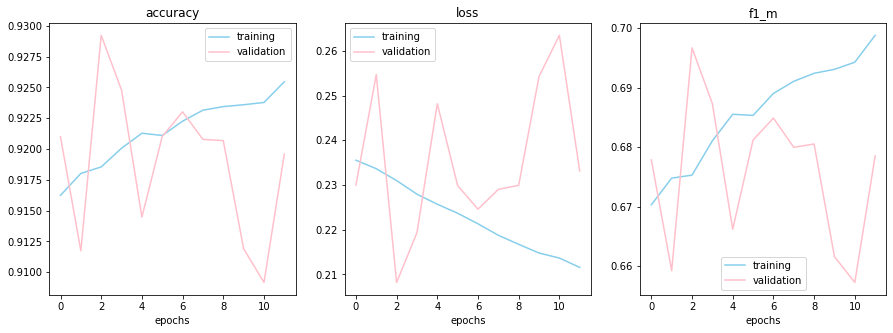

In [58]:
# Grafici koji prikazuju promene metrika tokom treniranja na trening skupu i validacionom skupu kroz epohe 

plot_graphs(binary_history, ['accuracy', 'loss', 'f1_m'])

### 6. Evaluacija modela

In [59]:
scores = binary_model.evaluate(X_test, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])
print('F1: ', scores[2])

2305/2305 [==============================] - 9s 2ms/step - loss: 0.2331 - accuracy: 0.9200 - f1_m: 0.6484
Loss:  0.23309126496315002
Test accuracy:  0.9199891686439514
F1:  0.6483532786369324


Predviđanje: 

In [60]:
y_predicted = binary_model.predict(X_test)

In [61]:
# sigmoidna funkcija:

y_labels = [int(score > 0.5) for score in y_predicted]

In [62]:
# F1 mera je bolja metrika kada su neizbalansirane klase

print('F1: ', metrics.f1_score(y_test, y_labels))

F1:  0.6841879884380687


In [63]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[61449  4877]
 [ 1023  6391]]


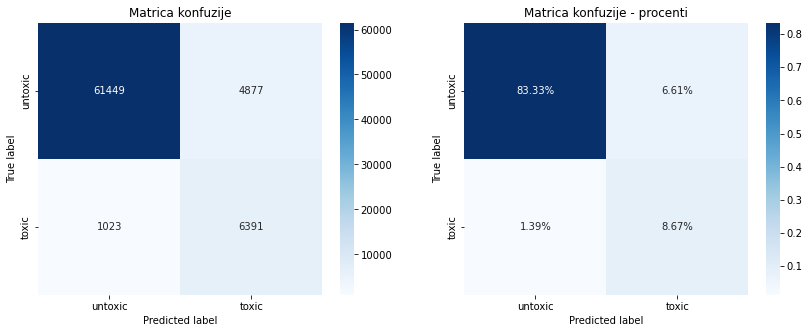

In [83]:
# funkcija koja prikazuje matricu konfuzije i 
# istu tu matricu sa vrednostima u  procentima

plot_cf(cf, 'binary', ['untoxic, toxic'])

#### - Od oko 90% procenata netoksičnih, 83.33% je tačno klasifikovano(TN), a 6.61% netačno(FP)
#### - Od oko 10% procenata toksičnih komentara, 8.67% je tačno klasifikovano(TP), a 1.39% netačno(FN)

In [78]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))

---------------------- IZVESTAJ -----------------------

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     66326
           1       0.57      0.86      0.68      7414

    accuracy                           0.92     73740
   macro avg       0.78      0.89      0.82     73740
weighted avg       0.94      0.92      0.93     73740



### Čuvanje modela

In [85]:
binary_model.save('models/binary_model.h5')

In [89]:
# model = keras.models.load_model('models/binary_model.h5', custom_objects={"f1_m": f1_m})

In [92]:
# model.get_config()